In [ ]:
# LTE-V XFR (row-level training) + block-level row-fusion (mean logits)
# - Training: same as your XFR script (row samples from XFR blocks)
# - Evaluation: block-level row-fusion: mean logits over rows (S=all or S=selected)

import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import h5py

# ================= 参数设置 =================
data_path = "E:/rf_datasets/"  # 数据文件夹（*.mat）

fs = 5e6
fc = 5.9e9
v_kmh = 120          # km/h
apply_doppler = True
apply_awgn = True

batch_size = 64
num_epochs = 300
learning_rate = 1e-4
weight_decay = 1e-3
in_planes = 64
dropout = 0.5
patience = 5
n_splits = 5
seed = 42

# 评估：row-fusion 选择行数
# S=None: 使用所有 L 行融合
# S=64/32等: 等间隔选 S 行融合（更接近“可部署折中”）
fusion_S = None

# ================= 随机种子 =================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed)

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v_kmh, fc_hz):
    c = 3e8
    v_ms = v_kmh / 3.6
    return (v_ms / c) * fc_hz

def apply_doppler_shift(signal_c, fd, fs):
    t = np.arange(signal_c.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal_c * doppler_phase

def add_awgn(signal_c, snr_db):
    signal_power = np.mean(np.abs(signal_c)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise_real = np.random.randn(*signal_c.shape)
    noise_imag = np.random.randn(*signal_c.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    return signal_c + noise

def power_normalize(signal_c, eps=1e-12):
    return signal_c / (np.sqrt(np.mean(np.abs(signal_c)**2)) + eps)

# ================= 兼容读取 v7.3 HDF5 dmrs 与 txID =================
def read_tx_id_str(rfDataset):
    txID_uint16 = rfDataset['txID'][:].flatten()
    tx_id = ''.join(chr(int(c)) for c in txID_uint16 if int(c) != 0)
    return tx_id

def read_dmrs_complex(rfDataset):
    dmrs = rfDataset['dmrs']
    # 情形1：Group，含 real/imag
    if isinstance(dmrs, h5py.Group):
        real = dmrs['real'][:]
        imag = dmrs['imag'][:]
        return real + 1j * imag
    # 情形2：Dataset，compound dtype
    arr = dmrs[:]
    if hasattr(arr, "dtype") and arr.dtype.fields is not None and ('real' in arr.dtype.fields) and ('imag' in arr.dtype.fields):
        return arr['real'] + 1j * arr['imag']
    # 情形3：已是 complex 或其它
    return arr

# ================= 数据加载（按 TX 聚合成 block，并做 XFR 转置） =================
def load_and_preprocess_with_grouping(
    mat_folder,
    group_size=288,              # 这里就是 XFR 的 m（每行长度）
    apply_doppler=False,
    target_velocity_kmh=120,
    apply_awgn=False,
    snr_db=20,
    fs=5e6,
    fc=5.9e9
):
    """
    输出：
      X_blocks: (num_blocks, L, m, 2)  其中 L=seg_len(=288), m=group_size
      y_blocks: (num_blocks,)
    逻辑：
      - 按 tx_id 分组文件
      - 每个 tx 的多个文件均衡抽样，拼成 group_size 帧
      - 然后 transpose 得到 (L, m, 2) 的“行样本集合”
    """
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    if len(mat_files) == 0:
        raise RuntimeError(f"在 {mat_folder} 未找到 .mat 文件")

    print(f"[INFO] 共找到 {len(mat_files)} 个 .mat 文件")
    fd = compute_doppler_shift(target_velocity_kmh, fc)
    print(f"[INFO] v={target_velocity_kmh} km/h，多普勒 fd={fd:.2f} Hz | SNR={snr_db} dB")

    # 1) 先加载所有文件的 dmrs 与 tx_id
    X_files, y_files, label_set = [], [], set()
    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_complex = read_dmrs_complex(rfDataset)      # (N, L) complex
            tx_id = read_tx_id_str(rfDataset)

        if dmrs_complex.ndim != 2:
            raise RuntimeError(f"dmrs维度异常: {dmrs_complex.shape} | file={file}")

        N, seg_len = dmrs_complex.shape

        processed = np.empty((N, seg_len, 2), dtype=np.float32)
        for i in range(N):
            sig = dmrs_complex[i, :]

            # 功率归一化（与 XFR 论文/代码一致）
            sig = power_normalize(sig)

            if apply_doppler:
                sig = apply_doppler_shift(sig, fd, fs)

            if apply_awgn:
                sig = add_awgn(sig, snr_db)

            processed[i, :, 0] = sig.real.astype(np.float32)
            processed[i, :, 1] = sig.imag.astype(np.float32)

        X_files.append(processed)     # (N, L, 2)
        y_files.append(tx_id)
        label_set.add(tx_id)

    # 2) 标签映射
    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}
    print(f"[INFO] 类别数={len(label_to_idx)} | label_to_idx={label_to_idx}")

    # 3) 为每个 TX 构造 blocks
    X_blocks_list = []
    y_blocks_list = []

    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue

        # 每个文件贡献 samples_per_file 帧，共 group_size 帧
        samples_per_file = group_size // num_files
        if samples_per_file == 0:
            print(f"[WARN] TX {label} 文件过多({num_files})，导致 samples_per_file=0，跳过")
            continue

        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            print(f"[WARN] TX {label} 样本不足，跳过")
            continue

        for g in range(max_groups):
            pieces = []
            for fi in files_idx:
                start = g * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]      # (samples_per_file, L, 2)
                pieces.append(piece)

            big_block = np.concatenate(pieces, axis=0)       # (group_size, L, 2)

            # XFR：transpose -> (L, group_size, 2)
            big_block = np.transpose(big_block, (1, 0, 2))   # (L, m, 2)

            X_blocks_list.append(big_block)
            y_blocks_list.append(label_to_idx[label])

    if len(X_blocks_list) == 0:
        raise RuntimeError("没有生成任何 block，请检查 group_size 和数据文件。")

    X_blocks = np.stack(X_blocks_list, axis=0).astype(np.float32)   # (Nblk, L, m, 2)
    y_blocks = np.array(y_blocks_list, dtype=np.int64)

    print(f"[INFO] blocks={X_blocks.shape[0]} | X_blocks={X_blocks.shape} | y_blocks={y_blocks.shape}")
    return X_blocks, y_blocks, label_to_idx

# ================= 1D ResNet18（与你原脚本一致） =================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=10, in_planes=64, dropout=0.0):
        super().__init__()
        self.in_planes = in_planes
        self.conv1 = nn.Conv1d(2, in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride, dropout):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes)
            )
        layers = [BasicBlock1D(self.in_planes, planes, stride, downsample, dropout)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, m, 2)  —— 注意这里序列长度是 m (=group_size)
        x = x.permute(0, 2, 1)  # (B, 2, m)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.squeeze(-1)
        return self.fc(x)

# ================= block-level row-fusion 评估（mean logits） =================
@torch.no_grad()
def evaluate_row_fusion(model, X_blocks, y_blocks, device, num_classes, S=None, block_batch_size=8):
    """
    X_blocks: torch.FloatTensor (Nblk, L, m, 2)
    y_blocks: torch.LongTensor  (Nblk,)
    S: None=all rows; else select S rows (equally spaced indices)
    """
    model.eval()
    Nblk, L, m, C = X_blocks.shape

    if S is None or S >= L:
        row_idx = None
    else:
        row_idx = np.linspace(0, L - 1, num=S, dtype=int)
        row_idx = np.unique(row_idx)

    correct, total = 0, 0
    all_labels, all_preds = [], []

    # 简单按 block 分 batch
    for start in range(0, Nblk, block_batch_size):
        end = min(Nblk, start + block_batch_size)
        blocks = X_blocks[start:end].to(device)      # (B, L, m, 2)
        labels = y_blocks[start:end].to(device)      # (B,)
        B = blocks.shape[0]

        if row_idx is not None:
            blocks = blocks[:, row_idx, :, :]        # (B, S, m, 2)
            L_eff = blocks.shape[1]
        else:
            L_eff = blocks.shape[1]

        flat = blocks.reshape(B * L_eff, m, C)       # (B*L_eff, m, 2)
        logits = model(flat)                         # (B*L_eff, K)
        logits = logits.reshape(B, L_eff, num_classes)
        fused_logits = logits.mean(dim=1)            # mean logits over rows
        preds = torch.argmax(fused_logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    acc = 100.0 * correct / max(total, 1)
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

# ================= row-level（单行样本）评估（可选参考） =================
@torch.no_grad()
def evaluate_row_level(model, X_blocks, y_blocks, device, num_classes, batch_size=256):
    """
    把 (Nblk, L, m, 2) 展开成 (Nblk*L, m, 2) 做 row-level accuracy（仅作参考，不作为主指标）
    """
    model.eval()
    Nblk, L, m, C = X_blocks.shape
    X = X_blocks.reshape(Nblk * L, m, C)
    y = y_blocks.repeat_interleave(L)

    correct, total = 0, 0
    all_labels, all_preds = [], []

    for start in range(0, X.shape[0], batch_size):
        end = min(X.shape[0], start + batch_size)
        xb = X[start:end].to(device)
        yb = y[start:end].to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_labels.extend(yb.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    acc = 100.0 * correct / max(total, 1)
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

def plot_confusion_matrix(cm, save_path=None, title="Confusion Matrix"):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    if save_path:
        plt.savefig(save_path)
    plt.close()

# ================= 主训练（按 block 划分；早停依据 fused val acc） =================
def train_for_snr(SNR_dB, save_folder, results_file, group_size=288, fusion_S=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] device={device}")

    # 1) 加载 blocks: (Nblk, L, m, 2)
    X_blocks_np, y_blocks_np, label_to_idx = load_and_preprocess_with_grouping(
        data_path,
        group_size=group_size,
        apply_doppler=apply_doppler,
        target_velocity_kmh=v_kmh,
        apply_awgn=apply_awgn,
        snr_db=SNR_dB,
        fs=fs,
        fc=fc
    )

    X_blocks = torch.from_numpy(np.ascontiguousarray(X_blocks_np)).float()
    y_blocks = torch.from_numpy(np.ascontiguousarray(y_blocks_np)).long()

    num_blocks, L, m, C = X_blocks.shape
    num_classes = len(label_to_idx)
    print(f"[INFO] blocks={num_blocks} | L={L} | m={m} | classes={num_classes}")

    # 2) block-level train/test split
    block_idx = np.arange(num_blocks)
    train_blocks, test_blocks = train_test_split(
        block_idx, test_size=0.25, random_state=seed, stratify=y_blocks_np
    )

    X_test_blk = X_blocks[test_blocks]
    y_test_blk = y_blocks[test_blocks]

    # 3) StratifiedKFold on train blocks
    y_train_lbl = y_blocks_np[train_blocks]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fold_test_fused = []
    fold_test_row = []

    for fold, (tr_i, va_i) in enumerate(skf.split(train_blocks, y_train_lbl), start=1):
        print(f"\n====== Fold {fold}/{n_splits} ======")
        tr_blocks = train_blocks[tr_i]
        va_blocks = train_blocks[va_i]

        # 构造 row-level 训练数据（展开 tr_blocks）
        X_tr = X_blocks[tr_blocks].reshape(-1, m, 2)                 # (Ntr*L, m, 2)
        y_tr = y_blocks[tr_blocks].repeat_interleave(L)              # (Ntr*L,)
        X_va_row = X_blocks[va_blocks].reshape(-1, m, 2)
        y_va_row = y_blocks[va_blocks].repeat_interleave(L)

        train_ds = TensorDataset(X_tr, y_tr)
        val_row_ds = TensorDataset(X_va_row, y_va_row)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_row_loader = DataLoader(val_row_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        model = ResNet18_1D(num_classes=num_classes, in_planes=in_planes, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        best_val_fused = -1.0
        best_state = None
        patience_cnt = 0

        for epoch in range(1, num_epochs + 1):
            # ---- train row-level ----
            model.train()
            tr_loss = 0.0
            tr_correct, tr_total = 0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                tr_correct += (preds == yb).sum().item()
                tr_total += yb.size(0)

            tr_loss /= max(len(train_loader), 1)
            tr_acc = 100.0 * tr_correct / max(tr_total, 1)

            # ---- val row-level (optional) ----
            model.eval()
            va_loss = 0.0
            va_correct, va_total = 0, 0
            with torch.no_grad():
                for xb, yb in val_row_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    va_loss += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    va_correct += (preds == yb).sum().item()
                    va_total += yb.size(0)
            va_loss /= max(len(val_row_loader), 1)
            va_acc_row = 100.0 * va_correct / max(va_total, 1)

            # ---- val fused (primary early stopping metric) ----
            X_va_blk = X_blocks[va_blocks]
            y_va_blk = y_blocks[va_blocks]
            va_acc_fused, _ = evaluate_row_fusion(
                model, X_va_blk, y_va_blk, device, num_classes, S=fusion_S, block_batch_size=8
            )

            log = (f"Fold{fold} Ep{epoch:03d} | "
                   f"TrainLoss {tr_loss:.4f} TrainRowAcc {tr_acc:.2f}% | "
                   f"ValLoss {va_loss:.4f} ValRowAcc {va_acc_row:.2f}% | "
                   f"ValFusedAcc(S={fusion_S if fusion_S is not None else 'all'}) {va_acc_fused:.2f}%")
            print(log)
            with open(results_file, "a") as f:
                f.write(log + "\n")

            if va_acc_fused > best_val_fused + 1e-6:
                best_val_fused = va_acc_fused
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_cnt = 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    print(f"[INFO] Early stop: {patience} epochs no improvement on fused val acc.")
                    break

            scheduler.step()

        # restore best
        if best_state is not None:
            model.load_state_dict(best_state)

        # ---- test fused ----
        test_acc_fused, test_cm_fused = evaluate_row_fusion(
            model, X_test_blk, y_test_blk, device, num_classes, S=fusion_S, block_batch_size=8
        )

        # ---- test row-level (reference) ----
        test_acc_row, _ = evaluate_row_level(model, X_test_blk, y_test_blk, device, num_classes, batch_size=256)

        fold_test_fused.append(test_acc_fused)
        fold_test_row.append(test_acc_row)

        plot_confusion_matrix(
            test_cm_fused,
            save_path=os.path.join(save_folder, f"cm_test_fused_fold{fold}.png"),
            title=f"Test CM (Fused, S={fusion_S if fusion_S is not None else 'all'})"
        )

        ckpt_path = os.path.join(save_folder, f"best_model_fold{fold}.pth")
        torch.save(model.state_dict(), ckpt_path)

        msg = (f"[RESULT] Fold {fold} | TestFusedAcc={test_acc_fused:.2f}% "
               f"| TestRowAcc(ref)={test_acc_row:.2f}% | ckpt={ckpt_path}")
        print(msg)
        with open(results_file, "a") as f:
            f.write(msg + "\n")

    mean_fused = float(np.mean(fold_test_fused))
    std_fused = float(np.std(fold_test_fused))
    mean_row = float(np.mean(fold_test_row))
    std_row = float(np.std(fold_test_row))

    summary = (f"\n[SUMMARY] SNR={SNR_dB} dB | group_size(m)={group_size} | "
               f"FusedAcc mean±std={mean_fused:.2f}%±{std_fused:.2f}% | "
               f"RowAcc(ref) mean±std={mean_row:.2f}%±{std_row:.2f}%\n")
    print(summary)
    with open(results_file, "a") as f:
        f.write(summary)

    return mean_fused

# ================= SNR 循环训练 + 绘制曲线（block-level fused acc） =================
if __name__ == "__main__":
    snr_list = list(range(20, -45, -5))
    snr_accs = []

    # 建议：group_size=288 对齐 RAW IQ 的 m=288 query
    group_size = 288

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTEV_XFR_RowFusion"
    out_root = os.path.join(os.getcwd(), "training_results",
                            f"{timestamp}_{script_name}_m{group_size}_S{fusion_S if fusion_S is not None else 'all'}")
    os.makedirs(out_root, exist_ok=True)

    for snr_db in snr_list:
        print(f"\n\n================== 当前实验 SNR={snr_db} dB ==================\n")
        folder_name = f"SNR{snr_db}dB_fd{int(compute_doppler_shift(v_kmh,fc))}"
        save_folder = os.path.join(out_root, folder_name)
        os.makedirs(save_folder, exist_ok=True)

        results_file = os.path.join(save_folder, "results.txt")
        with open(results_file, "a") as f:
            f.write(f"\n================ SNR={snr_db} dB =================\n")

        test_acc_fused = train_for_snr(
            snr_db, save_folder, results_file,
            group_size=group_size,
            fusion_S=fusion_S
        )
        snr_accs.append(test_acc_fused)
        print(f"[INFO] SNR {snr_db:>3} dB → results in: {save_folder}")

    # plot SNR vs fused acc
    plt.figure(figsize=(8,5))
    plt.plot(snr_list, snr_accs, marker='o', linestyle='-')
    plt.xlabel("SNR (dB)")
    plt.ylabel("Test Acc (Block-level Row-Fusion, %)")  # 主指标：block-level
    plt.title(f"LTE-V XFR Row-Fusion Accuracy (m={group_size}, S={fusion_S if fusion_S is not None else 'all'})")
    plt.grid(True)
    snr_curve_path = os.path.join(out_root, f"SNR_vs_fused_accuracy_{timestamp}.png")
    plt.savefig(snr_curve_path)
    plt.show()
    print(f"[INFO] 曲线已保存到: {snr_curve_path}")




================== 当前实验 SNR=20 dB ==================

[INFO] device=cuda
[INFO] 共找到 72 个 .mat 文件
[INFO] v=120 km/h，多普勒 fd=655.56 Hz | SNR=20 dB


读取数据: 100%|██████████| 72/72 [00:09<00:00,  7.74it/s]


[INFO] 类别数=9 | label_to_idx={'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8}
[INFO] blocks=747 | X_blocks=(747, 288, 288, 2) | y_blocks=(747,)
[INFO] blocks=747 | L=288 | m=288 | classes=9
Fold1 Ep001 | TrainLoss 1.4698 TrainRowAcc 45.96% | ValLoss 0.7464 ValRowAcc 74.69% | ValFused(all) 97.32%
Fold1 Ep002 | TrainLoss 0.5422 TrainRowAcc 81.87% | ValLoss 0.3172 ValRowAcc 89.22% | ValFused(all) 100.00%
Fold1 Ep003 | TrainLoss 0.3096 TrainRowAcc 89.82% | ValLoss 0.2144 ValRowAcc 92.78% | ValFused(all) 100.00%
Fold1 Ep004 | TrainLoss 0.2156 TrainRowAcc 93.03% | ValLoss 0.1675 ValRowAcc 94.51% | ValFused(all) 100.00%
Fold1 Ep005 | TrainLoss 0.1645 TrainRowAcc 94.70% | ValLoss 0.1508 ValRowAcc 95.18% | ValFused(all) 100.00%
Fold1 Ep006 | TrainLoss 0.1301 TrainRowAcc 95.96% | ValLoss 0.1292 ValRowAcc 95.91% | ValFused(all) 100.00%
Fold1 Ep007 | TrainLoss 0.1062 TrainRowAcc 96.68% | ValLoss 0.1103 ValRowAcc 96.49% | ValFused(all) 100.00%
[INFO] Early s

读取数据: 100%|██████████| 72/72 [00:09<00:00,  7.73it/s]


[INFO] 类别数=9 | label_to_idx={'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8}
[INFO] blocks=747 | X_blocks=(747, 288, 288, 2) | y_blocks=(747,)
[INFO] blocks=747 | L=288 | m=288 | classes=9
Fold1 Ep001 | TrainLoss 2.2109 TrainRowAcc 12.06% | ValLoss 2.6033 ValRowAcc 11.55% | ValFused(all) 11.61%
Fold1 Ep002 | TrainLoss 2.1769 TrainRowAcc 14.40% | ValLoss 2.4123 ValRowAcc 14.29% | ValFused(all) 13.39%
Fold1 Ep003 | TrainLoss 2.0757 TrainRowAcc 21.82% | ValLoss 2.0401 ValRowAcc 24.98% | ValFused(all) 42.86%
Fold1 Ep004 | TrainLoss 1.9466 TrainRowAcc 28.26% | ValLoss 1.8888 ValRowAcc 30.09% | ValFused(all) 54.46%
Fold1 Ep005 | TrainLoss 1.8573 TrainRowAcc 32.37% | ValLoss 1.8297 ValRowAcc 33.63% | ValFused(all) 76.79%
Fold1 Ep006 | TrainLoss 1.8026 TrainRowAcc 34.90% | ValLoss 1.7520 ValRowAcc 37.02% | ValFused(all) 77.68%
Fold1 Ep007 | TrainLoss 1.7627 TrainRowAcc 36.68% | ValLoss 1.7306 ValRowAcc 37.37% | ValFused(all) 65.18%
Fold1 Ep008 | TrainL

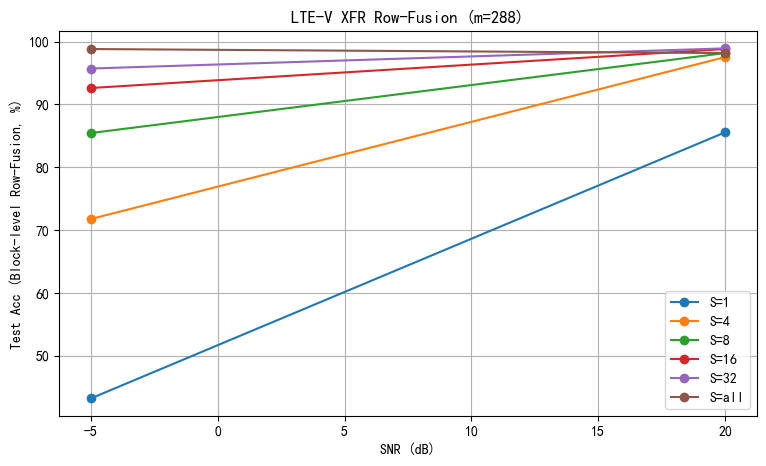

[INFO] SNR 曲线已保存: d:\Program\MW-RFF\MW-RFF\training_results\2026-01-21_19-02-30_LTEV_XFR_RowFusion_SaveAll_m288_EarlySall\SNR_vs_fusedAcc_multiS_2026-01-21_19-02-30.png


In [4]:
# LTE-V XFR (row-level training) + block-level row-fusion (mean logits)
# - Training: row samples from XFR blocks
# - Evaluation: block-level row-fusion over selected rows S in {1,4,8,16,32,'all'}
# - Save EVERYTHING needed for paper/repro: config/meta/splits/per-epoch logs/preds/CMs

import os
import glob
import json
import time
import platform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import h5py

# ================= 参数设置 =================
data_path = "E:/rf_datasets/"  # 数据文件夹（*.mat）

fs = 5e6
fc = 5.9e9
v_kmh = 120
apply_doppler = True
apply_awgn = True

batch_size = 64
num_epochs = 300
learning_rate = 1e-4
weight_decay = 1e-3
in_planes = 64
dropout = 0.5
patience = 5
n_splits = 5
seed = 42

# XFR: group_size = m（每行长度）
group_size = 288

# 评估：S 列表（推理预算）
S_LIST = [1, 4, 8, 16, 32, "all"]

# Early-stopping 依据：用哪个 S 的 fused val acc 来选 best epoch
EARLY_STOP_S = "all"   # 你也可改成 1（部署模式）或 32 等

# 混淆矩阵保存：PNG 图片只画少数 S，避免文件爆炸；npy 数值会全保存
PLOT_CM_S = [1, "all"]

# 是否保存 X_blocks（很大，单 SNR ~0.5GB，慎用）
SAVE_BLOCKS = False

# block-level evaluation batch size
block_batch_size = 8

# ================= 工具函数：保存 =================
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def save_json(obj, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def to_py(obj):
    # 把 numpy / torch 标量转 python 原生，方便 json
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if torch.is_tensor(obj) and obj.numel() == 1:
        return float(obj.item())
    return obj

# ================= 随机种子 =================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed)

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v_kmh, fc_hz):
    c = 3e8
    v_ms = v_kmh / 3.6
    return (v_ms / c) * fc_hz

def apply_doppler_shift(signal_c, fd, fs):
    t = np.arange(signal_c.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal_c * doppler_phase

def add_awgn(signal_c, snr_db):
    signal_power = np.mean(np.abs(signal_c)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise_real = np.random.randn(*signal_c.shape)
    noise_imag = np.random.randn(*signal_c.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    return signal_c + noise

def power_normalize(signal_c, eps=1e-12):
    return signal_c / (np.sqrt(np.mean(np.abs(signal_c)**2)) + eps)

# ================= 兼容读取 v7.3 HDF5 dmrs 与 txID =================
def read_tx_id_str(rfDataset):
    txID_uint16 = rfDataset['txID'][:].flatten()
    tx_id = ''.join(chr(int(c)) for c in txID_uint16 if int(c) != 0)
    return tx_id

def read_dmrs_complex(rfDataset):
    dmrs = rfDataset['dmrs']
    if isinstance(dmrs, h5py.Group):
        real = dmrs['real'][:]
        imag = dmrs['imag'][:]
        return real + 1j * imag
    arr = dmrs[:]
    if hasattr(arr, "dtype") and arr.dtype.fields is not None and ('real' in arr.dtype.fields) and ('imag' in arr.dtype.fields):
        return arr['real'] + 1j * arr['imag']
    return arr

# ================= 数据加载（按 TX 聚合成 block，并做 XFR 转置） =================
def load_and_preprocess_with_grouping(
    mat_folder,
    group_size=288,
    apply_doppler=False,
    target_velocity_kmh=120,
    apply_awgn=False,
    snr_db=20,
    fs=5e6,
    fc=5.9e9
):
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    if len(mat_files) == 0:
        raise RuntimeError(f"在 {mat_folder} 未找到 .mat 文件")

    print(f"[INFO] 共找到 {len(mat_files)} 个 .mat 文件")
    fd = compute_doppler_shift(target_velocity_kmh, fc)
    print(f"[INFO] v={target_velocity_kmh} km/h，多普勒 fd={fd:.2f} Hz | SNR={snr_db} dB")

    X_files, y_files, label_set = [], [], set()

    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_complex = read_dmrs_complex(rfDataset)      # (N, L) complex
            tx_id = read_tx_id_str(rfDataset)

        if dmrs_complex.ndim != 2:
            raise RuntimeError(f"dmrs维度异常: {dmrs_complex.shape} | file={file}")

        N, seg_len = dmrs_complex.shape

        processed = np.empty((N, seg_len, 2), dtype=np.float32)
        for i in range(N):
            sig = dmrs_complex[i, :]

            sig = power_normalize(sig)

            if apply_doppler:
                sig = apply_doppler_shift(sig, fd, fs)

            if apply_awgn:
                sig = add_awgn(sig, snr_db)

            processed[i, :, 0] = sig.real.astype(np.float32)
            processed[i, :, 1] = sig.imag.astype(np.float32)

        X_files.append(processed)     # (N, L, 2)
        y_files.append(tx_id)
        label_set.add(tx_id)

    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}
    print(f"[INFO] 类别数={len(label_to_idx)} | label_to_idx={label_to_idx}")

    X_blocks_list = []
    y_blocks_list = []

    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue

        samples_per_file = group_size // num_files
        if samples_per_file == 0:
            print(f"[WARN] TX {label} 文件过多({num_files})，导致 samples_per_file=0，跳过")
            continue

        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            print(f"[WARN] TX {label} 样本不足，跳过")
            continue

        for g in range(max_groups):
            pieces = []
            for fi in files_idx:
                start = g * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]      # (samples_per_file, L, 2)
                pieces.append(piece)

            big_block = np.concatenate(pieces, axis=0)       # (m, L, 2)

            # XFR: (m, L, 2) -> (L, m, 2)
            big_block = np.transpose(big_block, (1, 0, 2))   # (L, m, 2)

            X_blocks_list.append(big_block)
            y_blocks_list.append(label_to_idx[label])

    if len(X_blocks_list) == 0:
        raise RuntimeError("没有生成任何 block，请检查 group_size 和数据文件。")

    X_blocks = np.stack(X_blocks_list, axis=0).astype(np.float32)   # (Nblk, L, m, 2)
    y_blocks = np.array(y_blocks_list, dtype=np.int64)

    print(f"[INFO] blocks={X_blocks.shape[0]} | X_blocks={X_blocks.shape} | y_blocks={y_blocks.shape}")
    return X_blocks, y_blocks, label_to_idx

# ================= 1D ResNet18 =================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=10, in_planes=64, dropout=0.0):
        super().__init__()
        self.in_planes = in_planes
        self.conv1 = nn.Conv1d(2, in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride, dropout):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes)
            )
        layers = [BasicBlock1D(self.in_planes, planes, stride, downsample, dropout)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, m, 2)
        x = x.permute(0, 2, 1)  # (B, 2, m)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)

# ================= Dataset：row-level from blocks（避免巨大 reshape 占内存） =================
class RowFromBlocksDataset(Dataset):
    def __init__(self, X_blocks_t, y_blocks_t, block_ids):
        """
        X_blocks_t: (Nblk, L, m, 2)
        y_blocks_t: (Nblk,)
        block_ids:  1D array of global block indices
        """
        self.X = X_blocks_t
        self.y = y_blocks_t
        self.block_ids = np.asarray(block_ids, dtype=np.int64)
        self.L = int(X_blocks_t.shape[1])

    def __len__(self):
        return len(self.block_ids) * self.L

    def __getitem__(self, idx):
        b = idx // self.L
        r = idx % self.L
        blk_id = int(self.block_ids[b])
        x = self.X[blk_id, r]    # (m,2)
        y = self.y[blk_id]       # scalar
        return x, y

class BlockDatasetWithID(Dataset):
    def __init__(self, X_blocks_t, y_blocks_t, block_ids):
        self.X = X_blocks_t
        self.y = y_blocks_t
        self.block_ids = np.asarray(block_ids, dtype=np.int64)

    def __len__(self):
        return len(self.block_ids)

    def __getitem__(self, idx):
        blk_id = int(self.block_ids[idx])
        return self.X[blk_id], self.y[blk_id], blk_id   # (L,m,2), y, global_id

# ================= 评估：multi-S row-fusion（一次 forward 复用 logits） =================
@torch.no_grad()
def evaluate_row_fusion_multiS(model, block_loader, device, num_classes, row_perm_np, S_list):
    """
    row_perm_np: (Nblk, L) 固定随机排列，用于嵌套抽样
    返回：
      acc_dict: {S: acc%}
      cm_dict:  {S: cm ndarray}
      pred_dict:{S: preds ndarray (Nblocks,)}
      gt:       ndarray (Nblocks,)
      blk_ids:  ndarray (Nblocks,)
    """
    model.eval()
    acc_correct = {str(S): 0 for S in S_list}
    acc_total = 0

    all_gt = []
    all_blk = []
    all_pred = {str(S): [] for S in S_list}

    for blocks, labels, blk_ids in block_loader:
        blocks = blocks.to(device)     # (B, L, m, 2)
        labels = labels.to(device)     # (B,)
        blk_ids_np = np.asarray(blk_ids, dtype=np.int64)

        B, L, m, C = blocks.shape
        flat = blocks.reshape(B * L, m, C)                  # (B*L, m,2)
        logits = model(flat).reshape(B, L, num_classes)     # (B,L,K)

        for S in S_list:
            key = str(S)
            if S == "all" or S is None or (isinstance(S, int) and S >= L):
                fused = logits.mean(dim=1)                  # (B,K)
            else:
                S_int = int(S)
                sel = row_perm_np[blk_ids_np, :S_int]       # (B,S)
                sel_t = torch.from_numpy(sel).to(device).long()  # (B,S)
                idx = sel_t.unsqueeze(-1).expand(-1, -1, num_classes)  # (B,S,K)
                sel_logits = torch.gather(logits, dim=1, index=idx)    # (B,S,K)
                fused = sel_logits.mean(dim=1)              # (B,K)

            preds = torch.argmax(fused, dim=1)              # (B,)
            acc_correct[key] += (preds == labels).sum().item()
            all_pred[key].extend(preds.detach().cpu().numpy().tolist())

        acc_total += labels.size(0)
        all_gt.extend(labels.detach().cpu().numpy().tolist())
        all_blk.extend(blk_ids_np.tolist())

    gt = np.asarray(all_gt, dtype=np.int64)
    blk = np.asarray(all_blk, dtype=np.int64)

    acc_dict = {k: 100.0 * acc_correct[k] / max(acc_total, 1) for k in acc_correct.keys()}

    cm_dict = {}
    for S in S_list:
        key = str(S)
        preds = np.asarray(all_pred[key], dtype=np.int64)
        cm = confusion_matrix(gt, preds, labels=list(range(num_classes)))
        cm_dict[key] = cm

    pred_dict = {str(S): np.asarray(all_pred[str(S)], dtype=np.int64) for S in S_list}
    return acc_dict, cm_dict, pred_dict, gt, blk

@torch.no_grad()
def evaluate_row_level_acc(model, row_loader, device):
    model.eval()
    correct, total = 0, 0
    for xb, yb in row_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return 100.0 * correct / max(total, 1)

def plot_confusion_matrix(cm, save_path, title="Confusion Matrix"):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# ================= 主训练（按 block 划分；早停依据 fused val acc@EARLY_STOP_S） =================
def train_for_snr(SNR_dB, snr_folder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] device={device}")

    # ---- 保存 config/meta（每个 SNR 一份）----
    cfg = {
        "data_path": data_path,
        "fs": fs,
        "fc": fc,
        "v_kmh": v_kmh,
        "apply_doppler": apply_doppler,
        "apply_awgn": apply_awgn,
        "SNR_dB": SNR_dB,
        "group_size_m": group_size,
        "S_LIST": S_LIST,
        "EARLY_STOP_S": EARLY_STOP_S,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "in_planes": in_planes,
        "dropout": dropout,
        "patience": patience,
        "n_splits": n_splits,
        "seed": seed,
        "block_batch_size": block_batch_size,
        "SAVE_BLOCKS": SAVE_BLOCKS,
        "env": {
            "python": platform.python_version(),
            "torch": torch.__version__,
            "cuda_available": torch.cuda.is_available(),
            "device": str(device),
            "numpy": np.__version__,
        }
    }
    save_json(cfg, os.path.join(snr_folder, "config.json"))

    # 1) load blocks
    t0 = time.time()
    X_blocks_np, y_blocks_np, label_to_idx = load_and_preprocess_with_grouping(
        data_path,
        group_size=group_size,
        apply_doppler=apply_doppler,
        target_velocity_kmh=v_kmh,
        apply_awgn=apply_awgn,
        snr_db=SNR_dB,
        fs=fs,
        fc=fc
    )
    t_load = time.time() - t0

    # save label map
    save_json(label_to_idx, os.path.join(snr_folder, "label_to_idx.json"))

    # tensorize
    X_blocks = torch.from_numpy(np.ascontiguousarray(X_blocks_np)).float()
    y_blocks = torch.from_numpy(np.ascontiguousarray(y_blocks_np)).long()

    Nblk, L, m, C = X_blocks.shape
    num_classes = len(label_to_idx)
    print(f"[INFO] blocks={Nblk} | L={L} | m={m} | classes={num_classes}")

    # dataset meta
    counts = {}
    for k, v in label_to_idx.items():
        counts[k] = int(np.sum(y_blocks_np == v))
    meta = {
        "num_blocks": int(Nblk),
        "L": int(L),
        "m": int(m),
        "C": int(C),
        "num_classes": int(num_classes),
        "blocks_per_class": counts,
        "load_time_sec": float(t_load),
    }
    save_json(meta, os.path.join(snr_folder, "dataset_meta.json"))

    # optionally save blocks (VERY LARGE)
    if SAVE_BLOCKS:
        np.savez_compressed(
            os.path.join(snr_folder, "Xy_blocks.npz"),
            X_blocks=X_blocks_np.astype(np.float32),
            y_blocks=y_blocks_np.astype(np.int64)
        )

    # 2) fixed row permutation per block for nested S
    rng = np.random.default_rng(seed)
    row_perm = np.empty((Nblk, L), dtype=np.uint16)
    for i in range(Nblk):
        row_perm[i] = rng.permutation(L).astype(np.uint16)
    np.save(os.path.join(snr_folder, "row_perm.npy"), row_perm)

    # 3) block-level split train/test
    block_idx = np.arange(Nblk, dtype=np.int64)
    train_blocks, test_blocks = train_test_split(
        block_idx, test_size=0.25, random_state=seed, stratify=y_blocks_np
    )
    np.savez(
        os.path.join(snr_folder, "split_blocks.npz"),
        train_blocks=train_blocks.astype(np.int64),
        test_blocks=test_blocks.astype(np.int64)
    )

    # fixed test loader (block-level)
    test_ds = BlockDatasetWithID(X_blocks, y_blocks, test_blocks)
    test_loader = DataLoader(test_ds, batch_size=block_batch_size, shuffle=False)

    # for reference row-level acc on test (optional)
    test_row_ds = RowFromBlocksDataset(X_blocks, y_blocks, test_blocks)
    test_row_loader = DataLoader(test_row_ds, batch_size=256, shuffle=False, drop_last=False)

    # 4) StratifiedKFold on train blocks
    y_train_lbl = y_blocks_np[train_blocks]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # aggregate per-S across folds
    fold_results = []  # list of dicts

    # create summary CSV header later
    for fold, (tr_i, va_i) in enumerate(skf.split(train_blocks, y_train_lbl), start=1):
        fold_dir = ensure_dir(os.path.join(snr_folder, f"fold_{fold}"))
        tr_blocks = train_blocks[tr_i]
        va_blocks = train_blocks[va_i]

        # save fold split
        np.savez(
            os.path.join(fold_dir, "fold_blocks.npz"),
            tr_blocks=tr_blocks.astype(np.int64),
            va_blocks=va_blocks.astype(np.int64),
            test_blocks=test_blocks.astype(np.int64)
        )

        # row-level dataset loaders
        tr_row_ds = RowFromBlocksDataset(X_blocks, y_blocks, tr_blocks)
        va_row_ds = RowFromBlocksDataset(X_blocks, y_blocks, va_blocks)

        tr_loader = DataLoader(tr_row_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        va_row_loader = DataLoader(va_row_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # block-level val loader for fusion
        va_blk_ds = BlockDatasetWithID(X_blocks, y_blocks, va_blocks)
        va_blk_loader = DataLoader(va_blk_ds, batch_size=block_batch_size, shuffle=False)

        model = ResNet18_1D(num_classes=num_classes, in_planes=in_planes, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        # early stop tracking
        best_metric = -1.0
        best_epoch = -1
        best_state = None
        patience_cnt = 0

        # epoch logs
        # columns: epoch, train_loss, train_row_acc, val_loss, val_row_acc, val_fused_acc_S=...
        log_path = os.path.join(fold_dir, "epoch_log.csv")
        with open(log_path, "w", encoding="utf-8") as f:
            header = ["epoch", "train_loss", "train_row_acc", "val_loss", "val_row_acc"]
            for S in S_LIST:
                header.append(f"val_fused_acc_S={S}")
            f.write(",".join(header) + "\n")

        for epoch in range(1, num_epochs + 1):
            # ---- train ----
            model.train()
            tr_loss_sum = 0.0
            tr_correct, tr_total = 0, 0
            for xb, yb in tr_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                tr_loss_sum += loss.item()
                preds = torch.argmax(logits, dim=1)
                tr_correct += (preds == yb).sum().item()
                tr_total += yb.size(0)

            train_loss = tr_loss_sum / max(len(tr_loader), 1)
            train_row_acc = 100.0 * tr_correct / max(tr_total, 1)

            # ---- val row-level ----
            model.eval()
            va_loss_sum = 0.0
            va_correct, va_total = 0, 0
            with torch.no_grad():
                for xb, yb in va_row_loader:
                    xb = xb.to(device)
                    yb = yb.to(device)
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    va_loss_sum += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    va_correct += (preds == yb).sum().item()
                    va_total += yb.size(0)

            val_loss = va_loss_sum / max(len(va_row_loader), 1)
            val_row_acc = 100.0 * va_correct / max(va_total, 1)

            # ---- val fused (multi-S) ----
            val_fused_acc_dict, _, _, _, _ = evaluate_row_fusion_multiS(
                model, va_blk_loader, device, num_classes, row_perm, S_LIST
            )

            # choose early stop metric
            key_es = str(EARLY_STOP_S)
            metric = float(val_fused_acc_dict[key_es])

            # log to csv
            row = [epoch, train_loss, train_row_acc, val_loss, val_row_acc]
            for S in S_LIST:
                row.append(float(val_fused_acc_dict[str(S)]))
            with open(log_path, "a", encoding="utf-8") as f:
                f.write(",".join([f"{x:.6f}" if isinstance(x, float) else str(x) for x in row]) + "\n")

            print(f"Fold{fold} Ep{epoch:03d} | "
                  f"TrainLoss {train_loss:.4f} TrainRowAcc {train_row_acc:.2f}% | "
                  f"ValLoss {val_loss:.4f} ValRowAcc {val_row_acc:.2f}% | "
                  f"ValFused({EARLY_STOP_S}) {metric:.2f}%")

            # early stop update
            if metric > best_metric + 1e-6:
                best_metric = metric
                best_epoch = epoch
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_cnt = 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    print(f"[INFO] Early stop: {patience} epochs no improvement on fused val acc@S={EARLY_STOP_S}.")
                    break

            scheduler.step()

        # restore best
        if best_state is not None:
            model.load_state_dict(best_state)
        ckpt_path = os.path.join(fold_dir, "best_state.pth")
        torch.save(model.state_dict(), ckpt_path)

        # ---- test fused (multi-S) ----
        test_fused_acc_dict, test_cm_dict, test_pred_dict, gt_blk, blk_ids = evaluate_row_fusion_multiS(
            model, test_loader, device, num_classes, row_perm, S_LIST
        )

        # test row-level reference
        test_row_acc = evaluate_row_level_acc(model, test_row_loader, device)

        # save test metrics
        test_metrics = {
            "fold": fold,
            "best_epoch": best_epoch,
            "best_val_fused_acc_at_early_S": float(best_metric),
            "test_row_acc_ref": float(test_row_acc),
            "test_fused_acc": {k: float(v) for k, v in test_fused_acc_dict.items()},
            "ckpt_path": ckpt_path
        }
        save_json(test_metrics, os.path.join(fold_dir, "test_metrics.json"))

        # save preds/cms per S
        for S in S_LIST:
            key = str(S)
            np.savez(
                os.path.join(fold_dir, f"test_preds_S{key}.npz"),
                block_ids=blk_ids.astype(np.int64),
                y_true=gt_blk.astype(np.int64),
                y_pred=test_pred_dict[key].astype(np.int64)
            )
            np.save(os.path.join(fold_dir, f"cm_test_S{key}.npy"), test_cm_dict[key].astype(np.int64))

            if S in PLOT_CM_S:
                plot_confusion_matrix(
                    test_cm_dict[key],
                    save_path=os.path.join(fold_dir, f"cm_test_S{key}.png"),
                    title=f"Test CM (Fused, S={key})"
                )

        fold_results.append(test_metrics)

        print(f"[RESULT] Fold {fold} | TestRowAcc(ref)={test_row_acc:.2f}% | "
              f"TestFusedAcc@S={EARLY_STOP_S}={test_fused_acc_dict[str(EARLY_STOP_S)]:.2f}% | ckpt={ckpt_path}")

    # ---- aggregate across folds for this SNR ----
    agg = {"SNR_dB": int(SNR_dB), "folds": fold_results}
    # mean/std per S
    fused_means = {}
    fused_stds = {}
    for S in S_LIST:
        key = str(S)
        vals = [fr["test_fused_acc"][key] for fr in fold_results]
        fused_means[key] = float(np.mean(vals))
        fused_stds[key] = float(np.std(vals))
    row_vals = [fr["test_row_acc_ref"] for fr in fold_results]
    agg["test_row_acc_ref_mean"] = float(np.mean(row_vals))
    agg["test_row_acc_ref_std"] = float(np.std(row_vals))
    agg["test_fused_acc_mean"] = fused_means
    agg["test_fused_acc_std"] = fused_stds

    save_json(agg, os.path.join(snr_folder, "summary.json"))

    # also save a simple CSV for quick plotting
    csv_path = os.path.join(snr_folder, "summary_by_S.csv")
    with open(csv_path, "w", encoding="utf-8") as f:
        cols = ["S", "mean_acc", "std_acc"]
        f.write(",".join(cols) + "\n")
        for S in S_LIST:
            key = str(S)
            f.write(f"{key},{fused_means[key]:.6f},{fused_stds[key]:.6f}\n")

    return agg

# ================= SNR 循环训练 + 汇总保存 =================
if __name__ == "__main__":
    snr_list = [20,-5]

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTEV_XFR_RowFusion_SaveAll"
    out_root = ensure_dir(os.path.join(
        os.getcwd(),
        "training_results",
        f"{timestamp}_{script_name}_m{group_size}_EarlyS{EARLY_STOP_S}"
    ))

    # 保存全局 config（跨 SNR）
    global_cfg = {
        "timestamp": timestamp,
        "snr_list": snr_list,
        "group_size_m": group_size,
        "S_LIST": S_LIST,
        "EARLY_STOP_S": EARLY_STOP_S,
        "seed": seed,
        "out_root": out_root
    }
    save_json(global_cfg, os.path.join(out_root, "global_config.json"))

    all_summaries = []

    for snr_db in snr_list:
        print(f"\n\n================== 当前实验 SNR={snr_db} dB ==================\n")
        fd_int = int(compute_doppler_shift(v_kmh, fc))
        snr_folder = ensure_dir(os.path.join(out_root, f"SNR{snr_db}dB_fd{fd_int}"))

        summ = train_for_snr(snr_db, snr_folder)
        all_summaries.append(summ)
        print(f"[INFO] SNR {snr_db:>3} dB → results in: {snr_folder}")

    # 汇总成一张总表（每个 S 一列）
    # 保存为: out_root/snr_summary.csv
    summary_csv = os.path.join(out_root, "snr_summary.csv")
    with open(summary_csv, "w", encoding="utf-8") as f:
        cols = ["SNR_dB"]
        cols += [f"mean_S={S}" for S in S_LIST]
        cols += [f"std_S={S}" for S in S_LIST]
        cols += ["row_ref_mean", "row_ref_std"]
        f.write(",".join(cols) + "\n")

        for summ in all_summaries:
            row = [str(summ["SNR_dB"])]
            for S in S_LIST:
                row.append(f"{summ['test_fused_acc_mean'][str(S)]:.6f}")
            for S in S_LIST:
                row.append(f"{summ['test_fused_acc_std'][str(S)]:.6f}")
            row.append(f"{summ['test_row_acc_ref_mean']:.6f}")
            row.append(f"{summ['test_row_acc_ref_std']:.6f}")
            f.write(",".join(row) + "\n")

    print(f"[INFO] 汇总 CSV 已保存: {summary_csv}")

    # 可选：画 SNR vs Acc 曲线（每个 S 一条）
    # 注意：不指定颜色，交给 matplotlib 默认配色
    plt.figure(figsize=(9, 5))
    for S in S_LIST:
        ys = [summ["test_fused_acc_mean"][str(S)] for summ in all_summaries]
        plt.plot(snr_list, ys, marker='o', linestyle='-', label=f"S={S}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Test Acc (Block-level Row-Fusion, %)")
    plt.title(f"LTE-V XFR Row-Fusion (m={group_size})")
    plt.grid(True)
    plt.legend()
    fig_path = os.path.join(out_root, f"SNR_vs_fusedAcc_multiS_{timestamp}.png")
    plt.savefig(fig_path)
    plt.show()
    print(f"[INFO] SNR 曲线已保存: {fig_path}")
